# TUTORIAL
# Data assimilation of azhimuthal thermoacoustics: twin experiments 



In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)


if os.path.isdir('/mscott/'):
    data_folder = '/mscott/an553/data/'  # set working directory to 
else:
    data_folder = "../data/"

## 1. Create true data 
Create the reference truth and the observations.

*The code below can be compacted with the function ```create_truth```, which outputs a dictionary:*
```
  
from essentials.create import create_truth
truth = create_truth(model=Annular, manual_bias=manual_bias, **true_params)
```

In [2]:
from essentials.physical_models import Annular

ER = 0.5625
true_params = dict(nu=Annular.nu_from_ER(ER),
                   c2beta=Annular.c2beta_from_ER(ER),
                   std_obs=0.1,
                   noise_type='pink, add'
                   )
case = Annular(**true_params)

reference_params = case.alpha0

for reset in [1, 0, 0]:
    psi, t = case.time_integrate(int(case.t_transient / case.dt))
    if reset:
        case.update_history(psi[-1], reset=reset)
    else:
        case.update_history(psi, t, reset=reset)
        

Model dict_keys(['std_obs', 'noise_type']) not assigned


In [3]:
# Retrieve observables
y_true, t_true = case.get_observable_hist(), case.hist_t

# define the bias function
def manual_bias(yy, tt):
    bb = 0.2 * np.max(abs(yy))
    return bb, 'manual_offset_bias'

# Add bias to the reference data
b_true, name_bias = manual_bias(y_true, t_true)
y_true +=  b_true

# Add noise to the raw data
from  essentials.create import create_noisy_signal
y_raw = create_noisy_signal(y_true, noise_type=true_params['noise_type'], noise_level=true_params['std_obs'])


y_true, y_raw = [yy.squeeze() for yy in [y_true, y_raw]] 

In [4]:
# Select the observations time-window
t_start = Annular.t_transient 
t_stop = t_start + Annular.t_CR * 10
Nt_obs = 35

# Sample the observations
dt_t = t_true[1] - t_true[0]
obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + 1, Nt_obs, dtype=int)
y_obs, t_obs = [xx[obs_idx] for xx in [y_raw, t_true]]


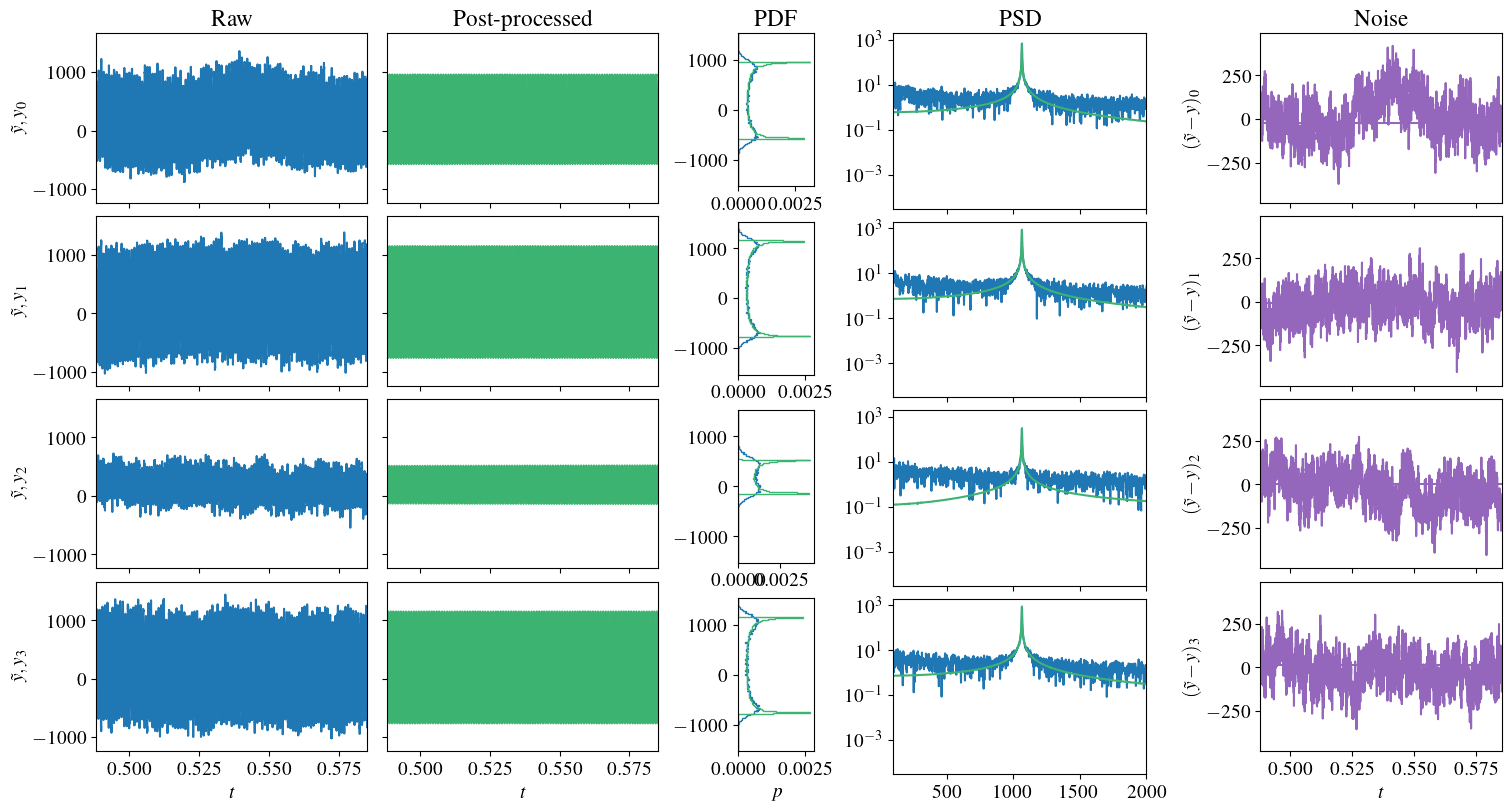

In [5]:
from essentials.plotResults import plot_truth

plot_truth(y_obs=y_obs, y_raw=y_raw, t=t_true, dt=dt_t, y_true=y_true, t_obs=t_obs)


## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble

*The code below can be compacted as*
```
from essentials.create import create_ensemble
ensemble = create_ensemble(model=Annular, **filter_params)
```

In [6]:
print(case.alpha0)
6848 / 2 / np.pi

{'omega': 6848.671984825749, 'nu': 25.105625000000032, 'c2beta': 37.02375000000002, 'kappa': 0.00012, 'epsilon': 0.0023, 'theta_b': 0.63, 'theta_e': 0.66}


1089.8930502932992

In [7]:
alpha0 = dict(nu=(20., 30.),
              c2beta=(30, 40),
              kappa=(1.E-4, 1.3E-4),
              epsilon=(0.001, 0.03),
              omega=(1085 * 2 * np.pi, 1100 * 2 * np.pi),
              theta_b=(0.5, 0.7),
              theta_e=(0.5, 0.8)
              )

alpha0_mean = dict()
for alpha, lims in alpha0.items():
    alpha0_mean[alpha] = 0.5 * (lims[0] + lims[1])

ensemble = Annular(**alpha0_mean)

filter_params = {'m': 10, 
                 'inflation': 1.001,
                 'std_psi': 0.3,
                 'std_a': alpha0}

# Forecast model to initialise the ensemble after transient
state, t_ = ensemble.time_integrate(int(ensemble.t_CR / ensemble.dt))
ensemble.update_history(state[-1], reset=True)

ensemble.init_ensemble(**filter_params)

ensemble_no_bias = ensemble.copy()



Visualize ensemble initialization

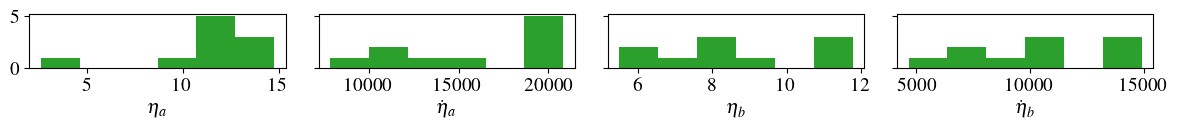

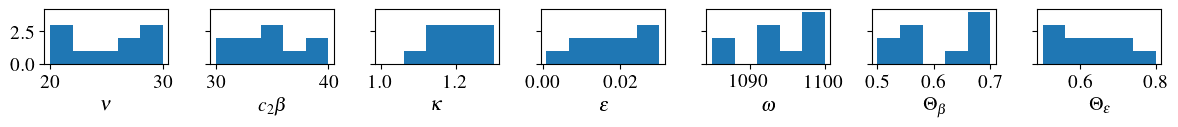

In [8]:
from essentials.plotResults import plot_ensemble
plot_ensemble(ensemble, reference_params={'kappa': 1e-4, 'omega': 2 * np.pi})

## 4. Train an ESN to model the model bias
The procedure is the following

&emsp; i. Initialise ESN Bias class object
&emsp; ii. Create synthetic bias to use as training data 
&emsp; iii. Train the ESN
&emsp; iv. Create washout data

<br><br>
**4.1. Initialise the ESN**

In [9]:
from essentials.bias_models import ESN
from essentials.create import create_bias_training_dataset


train_params = dict(bias_model=ESN, 
                    upsample=5,
                    N_units=50,
                    N_wash=10,
                    t_train=ensemble.t_CR * 20,
                    t_val=ensemble.t_CR * 5,
                    # Training data generation options
                    augment_data=True,
                    L=10,
                    noise=0.01, 
                    # Hyperparameter search ranges
                    rho_range=(0.5, 1.1),
                    sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                    tikh_range=[1e-16]
                    )
ensemble.init_bias(**train_params)



**4.2. Create training data**

The details of the code inside ```create_bias_training_dataset()``` function is explained in the tutorial ```Class_Bias.ipynb```.

In [10]:
train_data = create_bias_training_dataset(y_raw, y_true, ensemble, **train_params)


**4.3. Train the ESN**

The training convergence, hyperparameter optimization and testing results are saved in a pdf file in *figs_ESN* folder.

observed_idx [0 1 2 3] -> [0 1 2 3]
t_train 0.2 -> 0.2
t_val 0.05 -> 0.05
augment_data True -> True
bayesian_update False -> False
biased_observations False -> False
L 10 -> 10

 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 5.000e-01	 1.000e-05	 1.000e-16	 -4.7728
2	 5.000e-01	 1.000e-03	 1.000e-16	 -4.4109
3	 5.000e-01	 1.000e-01	 1.000e-16	 -4.6330
4	 5.000e-01	 1.000e+01	 1.000e-16	 -3.6609
5	 7.000e-01	 1.000e-05	 1.000e-16	 -4.9180
6	 7.000e-01	 1.000e-03	 1.000e-16	 -4.5673
7	 7.000e-01	 1.000e-01	 1.000e-16	 -4.2922
8	 7.000e-01	 1.000e+01	 1.000e-16	 -3.1826
9	 9.000e-01	 1.000e-05	 1.000e-16	 -5.1893
10	 9.000e-01	 1.000e-03	 1.000e-16	 -4.9028
11	 9.000e-01	 1.000e-01	 1.000e-16	 -4.3976
12	 9.000e-01	 1.000e+01	 1.000e-16	 -3.0358
13	 1.100e+00	 1.000e-05	 1.000e-16	 1.7651
14	 1.100e+00	 1.000e-03	 1.000e-16	 3.4372
15	 1.100e+00	 1.000e-01	 1.000e-16	 0.3167
16	 1.100e+00	 1

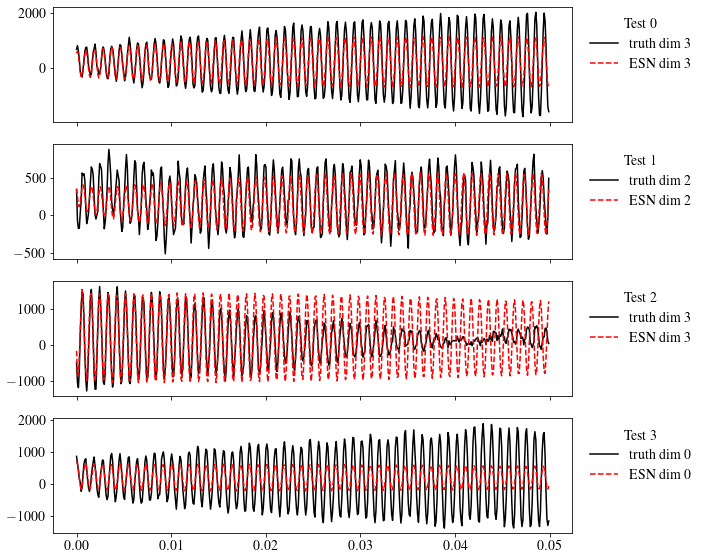

In [11]:
ensemble.bias.train_bias_model(**train_data)

**4.4. Create washout data**

We retrieve from the raw data a ```N_wash``` number of observations to use for initialising the ESN, i.e., to perform the washout. 
The ESN initialization must be before the fist observation.

In [12]:
ensemble.bias.t_init = t_obs[0] - 2 * Nt_obs * dt_t

i1 = np.argmin(abs(ensemble.bias.t_init - t_true))
i0 = i1 - ensemble.bias.N_wash  * ensemble.bias.upsample 

wash_obs = y_raw[i0:i1 + 1:ensemble.bias.upsample]
wash_t = t_true[i0:i1 + 1:ensemble.bias.upsample]

## 5. Apply data assimilation
We now have all the ingredients to start our data assimilation algorithm.

In [13]:
ensemble_ESN = ensemble.copy()


In [17]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr  8 19:02:23 2022

@author: an553
"""

import time
import numpy as np
from scipy import linalg

rng = np.random.default_rng(6)


def dataAssimilation(ensemble, y_obs, t_obs, std_obs=0.2, **kwargs):

    # Print simulation parameters ##
    ensemble.print_model_parameters()
    ensemble.bias.print_bias_parameters()
    print_DA_parameters(ensemble, t_obs)

    # FORECAST UNTIL FIRST OBS ##
    time1 = time.time()
    Nt = int(np.round((t_obs[0] - ensemble.get_current_time) / ensemble.dt))

    ensemble = forecastStep(ensemble, Nt, **kwargs)

    if ensemble.bias_bayesian_update and ensemble.bias.N_ens != ensemble.m:
        raise AssertionError('Wrong ESN initialisation')

    print('Elapsed time to first observation: ' + str(time.time() - time1) + ' s')

    #  ASSIMILATION LOOP ##
    ti, ensemble.activate_bias_aware, ensemble.activate_parameter_estimation = 0, False, False
    time1 = time.time()
    print_i = int(len(t_obs) / 10) * np.array([range(10)])

    # Define observation covariance matrix
    Cdd = np.diag((std_obs * np.ones(ensemble.Nq))) * np.max(abs(y_obs), axis=0) ** 2

    print('Assimilation progress: \n\t0 % ', end="")
    while True:
        ensemble.activate_bias_aware = ti >= ensemble.num_DA_blind
        ensemble.activate_parameter_estimation = ti >= ensemble.num_SE_only

        # ------------------------------  PERFORM ASSIMILATION ------------------------------ #
        Aa = analysisStep(ensemble, y_obs[ti], Cdd)  # Analysis step

        # -------------------------  UPDATE STATE AND BIAS ESTIMATES------------------------- #
        ensemble.update_history(Aa[:-ensemble.Nq, :], update_last_state=True)

        # Update bias using the analysis innovation d - y^a
        Ya = ensemble.get_observables()

        # Update the bias state
        if not ensemble.bias_bayesian_update or ensemble.bias.name == 'NoBias':
            b = np.expand_dims(y_obs[ti] - np.mean(Ya, -1), -1)
            ensemble.bias.update_history(b=b, update_last_state=True)
        else:
            # Analysis innovations
            I_a = y_obs[ti] - Ya

            if ensemble.bias.update_reservoir:
                Bf = ensemble.bias.get_bias(full_state=True, concat_reservoir_state=True)
            else:
                Bf = ensemble.bias.get_bias(full_state=True)

            Cii = Cdd
            Ba = EnKF(Bf, I_a, np.eye(ensemble.Nq), Cii)[0]
            # Update ESN states
            N_dim = ensemble.bias.N_dim
            ensemble.bias.update_history(b=Ba[:N_dim], update_last_state=True)
            # ESN specific
            if ensemble.bias.update_reservoir:
                ensemble.bias.reset_state(u=Ba[:N_dim], r=Ba[N_dim:])
            else:
                ensemble.bias.reset_state(u=Ba[:N_dim])

        # ------------------------------ FORECAST TO NEXT OBSERVATION ---------------------- #
        ti += 1
        if ti >= len(t_obs):
            print('100% ----------------\n')
            break
        elif ti in print_i:
            print(int(np.round(ti / len(t_obs) * 100, decimals=0)), end="% ")

        Nt = int(np.round((t_obs[ti] - ensemble.get_current_time) / ensemble.dt))
        # Parallel forecast
        ensemble = forecastStep(ensemble, Nt)

        assert ensemble.hist_t[-1] == ensemble.bias.hist_t[-1]
    print('Elapsed time during assimilation: ' + str(time.time() - time1) + ' s')
    return ensemble


# =================================================================================================================== #


def forecastStep(case, Nt, **kwargs):
    """ Forecast step in the data assimilation algorithm. The state vector of
        one of the ensemble members is integrated in time
        Inputs:
            case: ensemble forecast as a class object
            Nt: number of time steps to forecast
            averaged: is the ensemble being forcast averaged?
            alpha: changeable parameters of the problem 
        Returns:
            case: updated case forecast Nt time steps
    """

    # Forecast ensemble and update the history
    psi, t = case.time_integrate(Nt)
    case.update_history(psi, t)

    # Forecast ensemble bias and update its history
    if case.bias is not None:
        y = case.get_observable_hist(Nt)
        b, t_b = case.bias.time_integrate(t=t, y=y, **kwargs)
        case.bias.update_history(b, t_b)

    if case.hist_t[-1] != case.bias.hist_t[-1]:
        raise AssertionError('t assertion', case.hist_t[-1], case.bias.hist_t[-1])
    return case


def analysisStep(case, d, Cdd):
    """ Analysis step in the data assimilation algorithm. First, the ensemble
        is augmented with parameters and/or bias and/or state
        Inputs:
            case: ensemble forecast as a class object
            d: observation at time t
            Cdd: observation error covariance matrix
        Returns:
            Aa: analysis ensemble (or Af is Aa is not real)
    """

    Af = case.get_current_state  # state matrix [modes + params] x m
    M = case.M.copy()
    Cdd = Cdd.copy()

    if case.est_a and not case.activate_parameter_estimation:
        Af = Af[:-case.Na, :]
        M = M[:, :-case.Na]

    # --------------- Augment state matrix with biased Y --------------- #
    y = case.get_observables()
    Af = np.vstack((Af, y))
    # ======================== APPLY SELECTED FILTER ======================== #
    if case.filter == 'EnSRKF':
        Aa = EnSRKF(Af, d, Cdd, M)
    elif case.filter == 'EnKF':
        Aa = EnKF(Af, d, Cdd, M)
    elif case.filter == 'rBA_EnKF':
        # ----------------- Retrieve bias and its Jacobian ----------------- #
        b = case.bias.get_current_bias
        J = case.bias.state_derivative()
        # -------------- Define bias Covariance and the weight -------------- #
        k = case.regularization_factor
        Cbb = Cdd.copy()  # Bias covariance matrix same as obs cov matrix for now

        if case.activate_bias_aware:
            Aa = rBA_EnKF(Af, d, Cdd, Cbb, k, M, b, J)
        else:
            Aa = EnKF(Af, d, Cdd, M)
    else:
        raise ValueError('Filter ' + case.filter + ' not defined.')

    # ============================ CHECK PARAMETERS AND INFLATE =========================== #
    if not case.est_a:
        Aa = inflateEnsemble(Af, case.inflation, d=d, additive=True)
    else:
        if not case.activate_parameter_estimation:
            Af_params = Af[-case.Na:, :]
            Aa = inflateEnsemble(Af, case.inflation, d=d, additive=True)
            Aa = np.concatenate((Aa[:-case.Nq, :], Af_params, Aa[-case.Nq:, :]))
        else:
            is_physical, idx_alpha, d_alpha = checkParams(Aa, case)
            if is_physical:
                Aa = inflateEnsemble(Aa, case.inflation)
            else:
                case.is_not_physical()  # Count non-physical parameters
                if not hasattr(case, 'rejected_analysis'):
                    case.rejected_analysis = []
                if not case.constrained_filter:
                    print('reject-inflate')
                    Aa = inflateEnsemble(Af, case.reject_inflation, d=d, additive=True)
                    case.rejected_analysis.append([(case.get_current_time, np.dot(case.Ma, Aa), np.dot(case.Ma, Af), None)])
                else:
                    raise NotImplementedError('Constrained filter yet to test')
                    # # Try assimilating the parameters themselves
                    # Alphas = np.dot(case.Ma, Af)[idx_alpha]
                    # M_alpha = np.vstack([M, case.Ma[idx_alpha]])
                    # Caa = np.eye(len(idx_alpha)) * np.var(Alphas, axis=-1)  # ** 2
                    # # Store
                    # case.rejected_analysis.append([(case.t, np.dot(case.Ma, Aa),
                    #                                 np.dot(case.Ma, Af), (d_alpha, Caa))])
                    # C_zeros = np.zeros([case.Nq, len(idx_alpha)])
                    # Cdd_alpha = np.block([[Cdd, C_zeros], [C_zeros.T, Caa]])
                    # d_alpha = np.concatenate([d, d_alpha])
                    #
                    # if case.filter == 'EnSRKF':
                    #     Aa = EnSRKF(Af, d_alpha, Cdd_alpha, M_alpha)
                    # elif case.filter == 'EnKF':
                    #     Aa = EnKF(Af, d_alpha, Cdd_alpha, M_alpha)
                    # elif case.filter == 'rBA_EnKF':
                    #     if case.activate_bias_aware:
                    #         Aa = rBA_EnKF(Af, d_alpha, Cdd_alpha, Cbb, k, M_alpha, b, J)
                    #     else:
                    #         Aa = EnKF(Af, d_alpha, Cdd_alpha, M_alpha)
                    #
                    # # double check point in case the inflation takes the ensemble out of parameter range
                    # if checkParams(Aa, case)[0]:
                    #     print('\t ok c-filter case')
                    #     Aa = inflateEnsemble(Aa, case.inflation)
                    # else:
                    #     print('! not ok c-filter case')
                    #     Aa = inflateEnsemble(Af, case.inflation)

            # Aa = Aa[:-case.Nq, :]
    return Aa


# =================================================================================================================== #
def inflateEnsemble(A, rho, d=None, additive=False):
    if type(additive) is str and 'add' in additive:
        A[:len(d)] += np.array([d * (rho - 1)]).T

    A_m = np.mean(A, -1, keepdims=True)
    return A_m + rho * (A - A_m)


def checkParams(Aa, case):
    alphas, lower_bounds, upper_bounds, ii = [], [], [], 0
    for param in case.est_a:
        lims = case.params_lims[param]
        vals = Aa[case.Nphi + ii, :]
        lower_bounds.append(lims[0])
        upper_bounds.append(lims[1])
        alphas.append(vals)
        ii += 1

    break_low = [lims is not None and any(val < lims) for val, lims in zip(alphas, lower_bounds)]
    break_up = [lims is not None and any(val > lims) for val, lims in zip(alphas, upper_bounds)]

    is_physical = True
    if not any(np.append(break_low, break_up)):
        return is_physical, None, None

    #  -----------------------------------------------------------------
    is_physical = False

    if not case.constrained_filter:
        if any(break_low):
            idx = np.argwhere(break_low).squeeze(axis=-1)
            for idx_ in idx:
                alpha_ = alphas[idx_]
                mean_, min_ = np.mean(alpha_), np.min(alpha_)
                bound_ = lower_bounds[idx_]
                if mean_ >= bound_:
                    print('t = {:.3f} r-i: min {} = {:.2f} < {:.2f}'.format(case.get_current_time,
                                                                            case.est_a[idx_], min_, bound_))
                else:
                    print('t = {:.3f} r-i: mean {} = {:.2f} < {:.2f}'.format(case.get_current_time,
                                                                             case.est_a[idx_], mean_, bound_))
        if any(break_up):
            idx = np.argwhere(break_up)
            if len(idx.shape) > 1:
                idx = idx.squeeze(axis=-1)
            for idx_ in idx:
                alpha_ = alphas[idx_]
                mean_, max_ = np.mean(alpha_), np.max(alpha_)
                bound_ = upper_bounds[idx_]
                if mean_ <= bound_:
                    print('t = {:.3f} r-i: max {} = {:.2f} > {:.2f}'.format(case.get_current_time,
                                                                            case.est_a[idx_], mean_, bound_))
                else:
                    print('t = {:.3f} r-i: mean {} = {:.2f} > {:.2f}'.format(case.get_current_time,
                                                                             case.est_a[idx_], mean_, bound_))
        return is_physical, None, None

    #  -----------------------------------------------------------------
    idx_alpha, d_alpha = [], []
    if any(break_low):
        idx = np.argwhere(break_low).squeeze(axis=0)
        for idx_ in idx:
            idx_alpha.append(idx_)
            alpha_ = alphas[idx_]
            mean_, min_ = np.mean(alpha_), np.min(alpha_)
            bound_ = lower_bounds[idx_]
            if mean_ >= bound_:
                d_alpha.append(np.max(alpha_) + np.std(alpha_))

                print('t = {:.3f}: min{}={:.2f}<{:.2f}. d_alph={:.2f}'.format(case.get_current_time, case.est_a[idx_],
                                                                              min_, bound_, d_alpha[-1]))
            else:
                d_alpha.append(bound_ + 2 * np.std(alphas[idx_]))
                print('t = {:.3f}: mean{}={:.2f}<{:.2f}. d_alph={:.2f}'.format(case.get_current_time, case.est_a[idx_],
                                                                               mean_, bound_, d_alpha[-1]))

    if any(break_up):
        idx = np.argwhere(break_up)
        if len(idx.shape) > 1:
            idx = idx.squeeze(axis=-1)
        for idx_ in idx:
            idx_alpha.append(idx_)
            alpha_ = alphas[idx_]

            mean_, max_ = np.mean(alpha_), np.max(alpha_)
            bound_ = upper_bounds[idx_]

            # min_ = np.min(alphas[idx_])
            if mean_ < bound_:
                # vv = alpha_[np.argwhere(alpha_ < bound_)]
                d_alpha.append(np.min(alpha_) - np.std(alpha_))
                # elif min_ < bound_:
                #     d_alpha.append(min_)
                print('t = {:.3f}: max{}={:.2f}>{:.2f}. d_alph={:.2f}'.format(case.get_current_time, case.est_a[idx_],
                                                                              max_, bound_, d_alpha[-1]))
            else:
                d_alpha.append(bound_ - 2 * np.std(alphas[idx_]))

                print('t = {:.3f}: mean{}={:.2f}>{:.2f}. d_alph={:.2f}'.format(case.get_current_time, case.est_a[idx_],
                                                                               mean_, bound_, d_alpha[-1]))

    return is_physical, np.array(idx_alpha, dtype=int), d_alpha

# =================================================================================================================== #
# =========================================== ENSEMBLE FILTERS ====================================================== #
# =================================================================================================================== #


def EnSRKF(Af, d, Cdd, M):
    """Ensemble Square-Root Kalman Filter based on Evensen (2009)
        Inputs:
            Af: forecast ensemble at time t
            d: observation at time t
            Cdd: observation error covariance matrix
            M: matrix mapping from state to observation space
        Returns:
            Aa: analysis ensemble (or Af is Aa is not real)
    """
    m = np.size(Af, 1)  # ensemble size
    d = np.expand_dims(d, axis=1)
    psi_f_m = np.mean(Af, 1, keepdims=True)
    Psi_f = Af - psi_f_m

    # Mapped mean and deviations
    y = np.dot(M, psi_f_m)
    S = np.dot(M, Psi_f)

    # Matrix to invert
    C = (m - 1) * Cdd + np.dot(S, S.T)
    L, Z = linalg.eig(C)
    Linv = linalg.inv(np.diag(L.real))

    X2 = np.dot(linalg.sqrtm(Linv), np.dot(Z.T, S))
    E, V = linalg.svd(X2)[1:]
    V = V.T
    if len(E) is not m:  # case for only one eigenvalue (q=1). The rest zeros.
        E = np.hstack((E, np.zeros(m - len(E))))
    E = np.diag(E.real)

    sqrtIE = linalg.sqrtm(np.eye(m) - np.dot(E.T, E))

    # Analysis mean
    Cm = np.dot(Z, np.dot(Linv, Z.T))
    psi_a_m = psi_f_m + np.dot(Psi_f, np.dot(S.T, np.dot(Cm, (d - y))))

    # Analysis deviations
    Psi_a = np.dot(Psi_f, np.dot(V, np.dot(sqrtIE, V.T)))
    Aa = psi_a_m + Psi_a

    if not np.isreal(Aa).all():
        Aa = Af
        print('Aa not real')
    return Aa


def EnKF(Af, d, Cdd, M):
    """Ensemble Kalman Filter as derived in Evensen (2009) eq. 9.27.
        Inputs:
            Af: forecast ensemble at time t
            d: observation at time t
            Cdd: observation error covariance matrix
            M: matrix mapping from state to observation space
        Returns:
            Aa: analysis ensemble (or Af is Aa is not real)
    """
    m = np.size(Af, 1)

    psi_f_m = np.mean(Af, 1, keepdims=True)
    Psi_f = Af - psi_f_m

    # Create an ensemble of observations
    D = rng.multivariate_normal(d, Cdd, m).transpose()

    # Mapped forecast matrix M(Af) and mapped deviations M(Af')
    Y = np.dot(M, Af)
    S = np.dot(M, Psi_f)

    # Matrix to invert
    C = (m - 1) * Cdd + np.dot(S, S.T)
    Cinv = linalg.inv(C)

    X = np.dot(S.T, np.dot(Cinv, (D - Y)))

    Aa = Af + np.dot(Af, X)

    if not np.isreal(Aa).all():
        Aa = Af
        print('Aa not real')
    return Aa


def rBA_EnKF(Af, d, Cdd, Cbb, k, M, b, J):
    """ Bias-aware Ensemble Kalman Filter.
        Inputs:
            Af: forecast ensemble at time t (augmented with Y) [N x m]
            d: observation at time t [Nq x 1]
            Cdd: observation error covariance matrix [Nq x Nq]
            Cbb: bias covariance matrix [Nq x Nq]
            k: bias penalisation factor
            M: matrix mapping from state to observation space [Nq x N]
            b: bias of the forecast observables (Y = MAf + B) [Nq x 1]
            J: derivative of the bias with respect to the input [Nq x Nq]
        Returns:
            Aa: analysis ensemble (or Af is Aa is not real)
    """
    Nm = np.size(Af, 1)
    Nq = len(d)

    Iq = np.eye(Nq)
    # Mean and deviations of the ensemble
    Psi_f = Af - np.mean(Af, 1, keepdims=True)
    S = np.dot(M, Psi_f)
    Q = np.dot(M, Af)

    # Create an ensemble of observations
    D = rng.multivariate_normal(d, Cdd, Nm).transpose()

    if b.ndim > 1 and b.shape[-1] == Nm:
        B = b
    else:
        if b.ndim == 1:
            b = np.expand_dims(b, axis=1)
        # B = rng.multivariate_normal(b.squeeze(), Cbb, Nm).transpose()
        B = np.repeat(b, Nm, axis=1)

    Y = Q + B

    Cqq = np.dot(S, S.T)  # covariance of observations M Psi_f Psi_f.T M.T
    if np.array_equiv(Cdd, Cbb):
        CdWb = Iq
    else:
        CdWb = np.dot(Cdd, linalg.inv(Cbb))

    Cinv = ((Nm - 1) * Cdd + np.dot(Iq + J, np.dot(Cqq, (Iq + J).T)) +
            k * np.dot(CdWb, np.dot(J, np.dot(Cqq, J.T))))

    K = np.dot(Psi_f, np.dot(S.T, linalg.inv(Cinv)))
    Aa = Af + np.dot(K, np.dot(Iq + J, D - Y) - k * np.dot(CdWb, np.dot(J, B)))


    if not np.isreal(Aa).all():
        print('Aa not real')
        Aa = Af

    return Aa


# =================================================================================================================== #


def print_DA_parameters(ensemble, t_obs):
    print('\n -------------------- ASSIMILATION PARAMETERS -------------------- \n',
          '\t Filter = {0}  \n\t bias = {1} \n'.format(ensemble.filter, ensemble.bias.name),
          '\t m = {} \n'.format(ensemble.m),
          '\t Time steps between analysis = {} \n'.format(ensemble.dt_obs),
          '\t Inferred params = {0} \n'.format(ensemble.est_a),
          '\t Inflation = {0} \n'.format(ensemble.inflation),
          '\t Ensemble std(psi0) = {}\n'.format(ensemble.std_psi),
          '\t Ensemble std(alpha0) = {}\n'.format(ensemble.std_a),
          '\t Number of analysis steps = {}, t0={}, t1={}'.format(len(t_obs), t_obs[0], t_obs[-1])
          )
    if ensemble.filter == 'rBA_EnKF':
        print('\t Bias penalisation factor k = {}\n'.format(ensemble.regularization_factor))
    print(' --------------------------------------------')


In [18]:
# from essentials.DA import dataAssimilation

std_obs = true_params['std_obs']

DA_kwargs = dict(y_obs=y_obs.squeeze(), t_obs=t_obs, std_obs=std_obs, wash_obs=wash_obs, wash_t=wash_t)

ensemble_ESN.filter = 'rBA_EnKF'
ensemble_ESN.regularization_factor = 1.
ensemble_no_bias.filter ='EnSRKF'


out = []
for ens in [ensemble_no_bias, ensemble_ESN]:
    ens = ens.copy()
    ens.t_init = t_obs[0]
    ens.inflation = 1.01
    
    filter_ens = dataAssimilation(ens, **DA_kwargs.copy())
    
    #Forecast the ensemble further without assimilation
    Nt_extra = int(filter_ens.t_CR / filter_ens.dt)
    
    psi, t = filter_ens.time_integrate(Nt_extra)
    filter_ens.update_history(psi, t)
    
    y = filter_ens.get_observable_hist(Nt_extra)
    b, t_b = filter_ens.bias.time_integrate(t=t, y=y)
    filter_ens.bias.update_history(b, t_b)
    
    out.append(filter_ens)



 ------------------ Annular Model Parameters ------------------ 
	 ER = 0.5
	 Nq = 4
	 c2beta = 35.0
	 dt = 1.95313e-05
	 epsilon = 0.0155
	 kappa = 0.000115
	 n = 1.0
	 nu = 25.0
	 omega = 6864.38
	 theta_b = 0.6
	 theta_e = 0.65

 ----------------  Bias model parameters ----------------  
 Bias model: NoBias

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = EnSRKF  
	 bias = NoBias 
 	 m = 10 
 	 Time steps between analysis = None 
 	 Inferred params = ['nu', 'c2beta', 'kappa', 'epsilon', 'omega', 'theta_b', 'theta_e'] 
 	 Inflation = 1.01 
 	 Ensemble std(psi0) = 0.3
 	 Ensemble std(alpha0) = {'nu': (20.0, 30.0), 'c2beta': (30, 40), 'kappa': (0.0001, 0.00013), 'epsilon': (0.001, 0.03), 'omega': (6817.256058289851, 6911.503837897545), 'theta_b': (0.5, 0.7), 'theta_e': (0.5, 0.8)}
 	 Number of analysis steps = 143, t0=0.488262, t1=0.585332
 --------------------------------------------
Elapsed time to first observation: 1.9616000652313232 s
Assimilation 

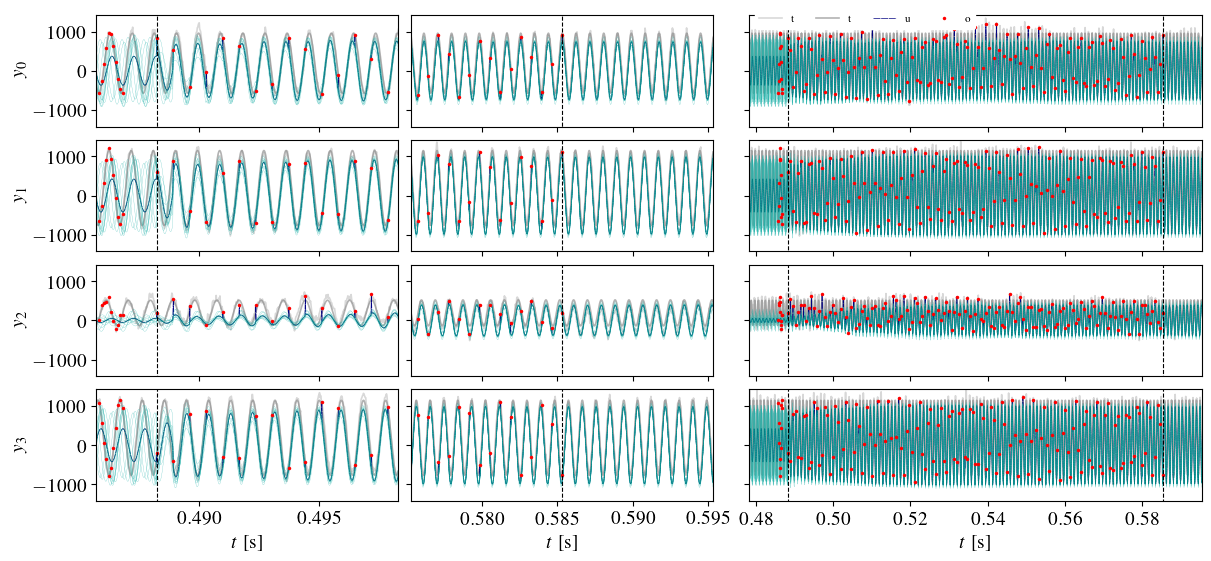

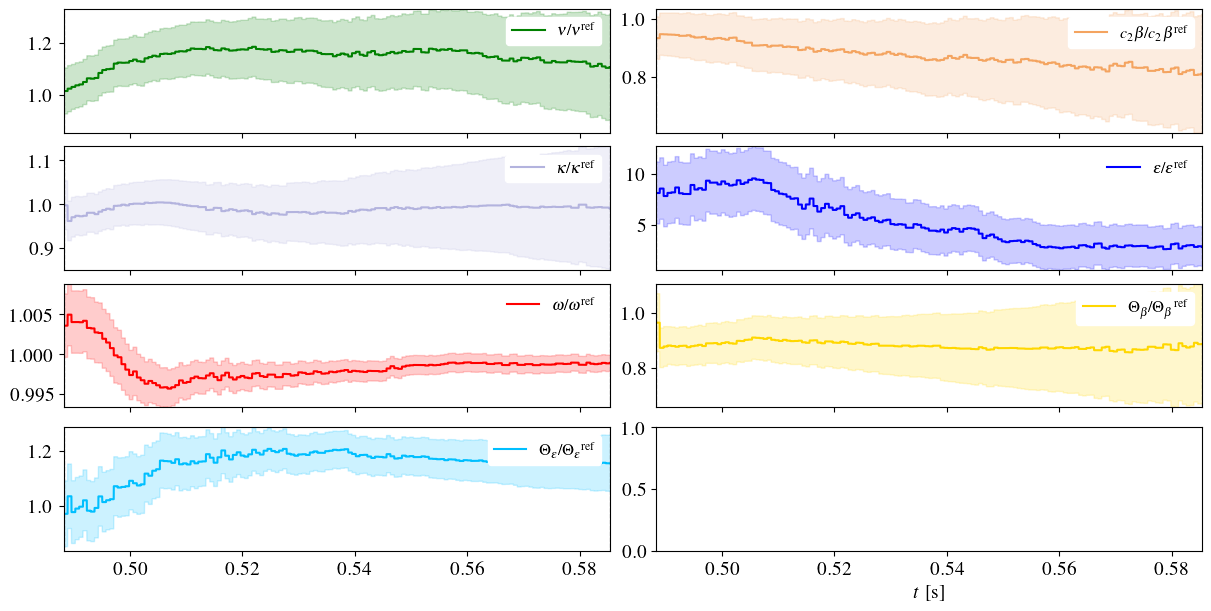

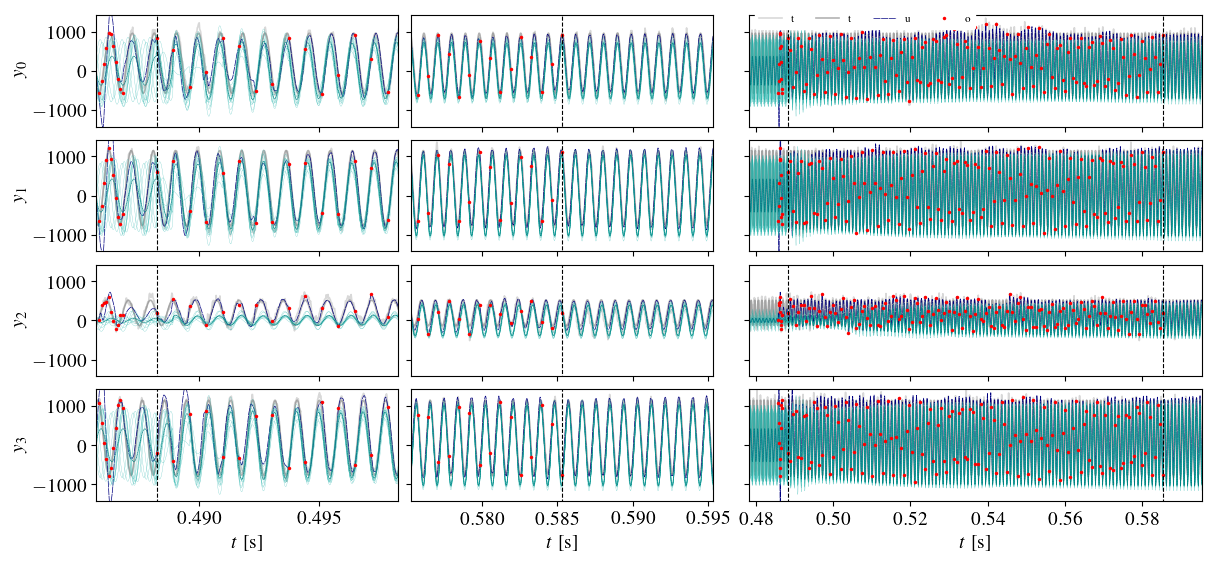

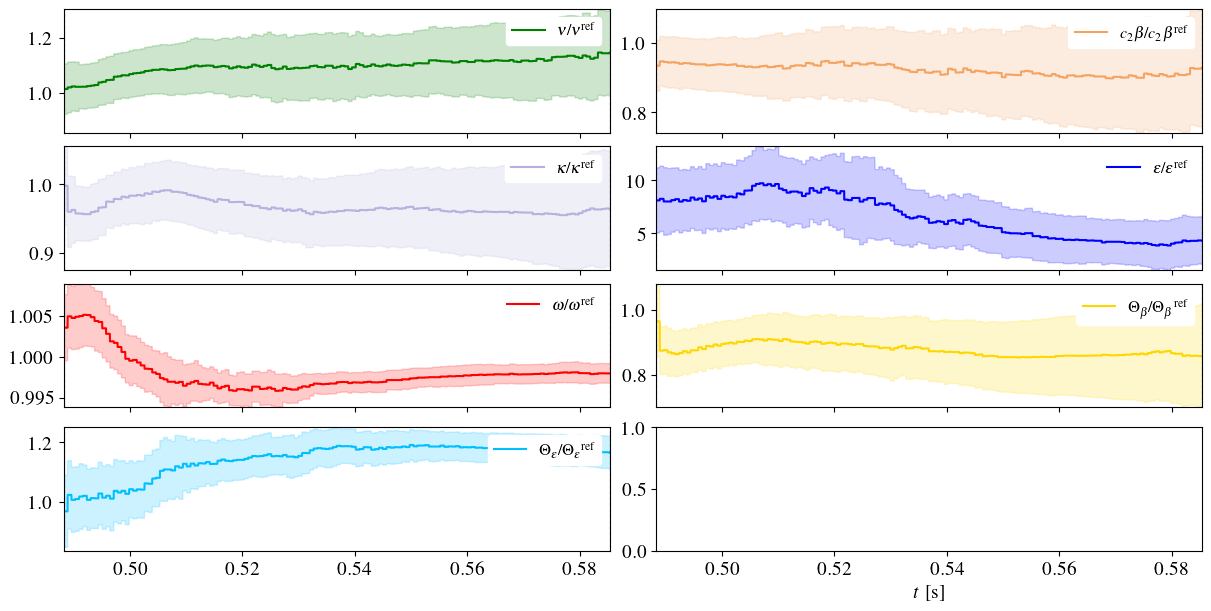

In [19]:
from essentials.plotResults import plot_timeseries, plot_parameters


truth = dict(y_raw=y_raw, y_true=y_true, t=t_true, dt=dt_t,
             t_obs=t_obs, y_obs=y_obs, dt_obs=Nt_obs * dt_t,
             std_obs=std_obs, wash_t=wash_t, wash_obs=wash_obs)

for filter_ens in out:
    plot_timeseries(filter_ens, truth)
    plot_parameters(filter_ens, truth, reference_p=case.alpha0)

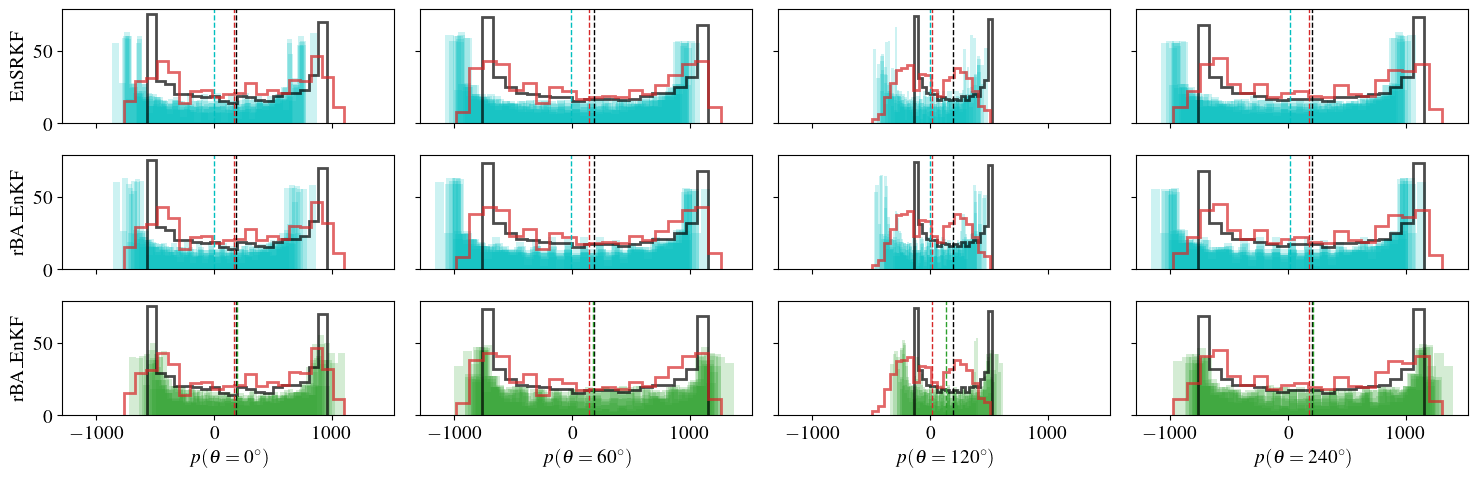

In [23]:
 # Plot RMS error
from essentials.Util import interpolate

Nq = y_true.shape[1]
fig, axs_all = plt.subplots(nrows=3, ncols=Nq, sharex=True, sharey='row', figsize=(15, 5), layout='tight')


i0 = np.argmin(abs(truth['t'] - truth['t_obs'][0] + ensemble.t_CR))
i1 = np.argmin(abs(truth['t'] - filter_ens.hist_t[-1]))

t_ref, y_ref_true, y_ref_raw = [truth[key][i0:i1] for key in ['t', 'y_true', 'y_raw']]
j0 = np.argmin(abs(t_ref- truth['t_obs'][-1]))
j1 = np.argmin(abs(t_ref- filter_ens.hist_t[-1]))


args_1 = dict(orientation='vertical', histtype='step', bins=20, density=False)
args_2 = dict(orientation='vertical', histtype='stepfilled', bins=30, density=False, alpha=0.2)

for filter_ens, axs in zip(out, axs_all[:2]):    
    
    y_est = filter_ens.get_observable_hist()   
    y_est = interpolate(filter_ens.hist_t, y_est, t_ref)

    for qi, ax in enumerate(axs):
        for mi in range(filter_ens.m):
            ax.hist(y_est[j0:j1, qi, mi], color='c', **args_2)
        ax.hist(y_ref_true[j0:j1, qi],  color='k', alpha=0.7, lw=2, **args_1)
        ax.hist(y_ref_raw[j0:j1, qi], color='tab:red', alpha=0.7, lw=2, **args_1)
        ax.axvline(np.mean(y_ref_true[j0:j1, qi]), color='k', ls='--', lw=1)
        ax.axvline(np.mean(y_ref_raw[j0:j1, qi]), color='tab:red', ls='--', lw=1)
        ax.axvline(np.mean(y_est[j0:j1, qi]), color='c', ls='--', lw=1)
    axs[0].set(ylabel=filter_ens.filter)

for filter_ens, axs in zip([out[-1]], [axs_all[-1]]):    
    
    y_est = filter_ens.get_observable_hist()   
    b_est = filter_ens.bias.hist
    
    y_est = interpolate(filter_ens.hist_t, y_est, filter_ens.bias.hist_t) + b_est
    
    y_est = interpolate(filter_ens.bias.hist_t, y_est, t_ref)

    for qi, ax in enumerate(axs):
        for mi in range(filter_ens.m):
            ax.hist(y_est[j0:j1, qi, mi], color='tab:green', **args_2)
        ax.hist(y_ref_true[j0:j1, qi],  color='k', alpha=0.7, lw=2, **args_1)
        ax.hist(y_ref_raw[j0:j1, qi], color='tab:red', alpha=0.7, lw=2, **args_1)
        ax.axvline(np.mean(y_ref_true[j0:j1, qi]), color='k', ls='--', lw=1)
        ax.axvline(np.mean(y_ref_raw[j0:j1, qi]), color='tab:red', ls='--', lw=1)
        ax.axvline(np.mean(y_est[j0:j1, qi]), color='tab:green', ls='--', lw=1)
    axs[0].set(ylabel=filter_ens.filter)
    
for ax, lbl in zip(axs_all[-1, :], filter_ens.obs_labels):
    ax.set(xlabel=lbl)

In [24]:
# TODO: Plot PDF of RMS
# TODO: Plot ensemble spread
# TODO: Plot timeseries PDF and PSD

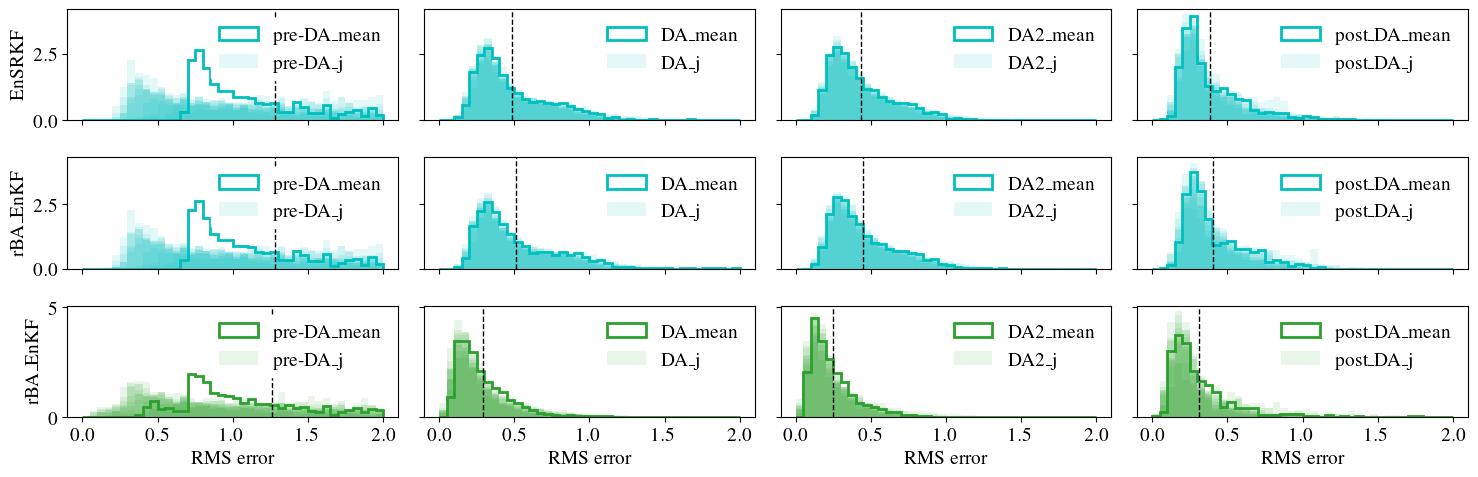

In [26]:
 # Plot RMS error
from essentials.Util import interpolate

fig, axs_all = plt.subplots(nrows=3, ncols=4, sharex=True, sharey='row', figsize=(15, 5), layout='tight')


i0 = np.argmin(abs(truth['t'] - truth['t_obs'][0] + ensemble.t_CR))
i1 = np.argmin(abs(truth['t'] - filter_ens.hist_t[-1]))

t_ref, y_ref = [truth[key][i0:i1] for key in ['t', 'y_raw']]
y_ref = np.expand_dims(y_ref, axis=-1)


args = dict(bins=40, range=(0, 2), density=True, orientation='vertical')
for filter_ens, axs in zip(out, axs_all):
    
    y_est = filter_ens.get_observable_hist()
    # y_est = np.mean(y_est, -1, keepdims=True)

    # y_est = interpolate(filter_ens.hist_t, y_est, filter_ens.bias.hist_t)
    # y_est += filter_ens.bias.hist
    # y_est = interpolate(filter_ens.bias.hist_t, y_est, t_ref)
    
    
    y_est = interpolate(filter_ens.hist_t, y_est, t_ref)
    
    
    # root-mean square error
    R = np.sqrt(np.sum((y_ref - y_est) ** 2, axis=1) / np.sum((y_ref) ** 2, axis=1))
    
    axs[0].set( ylabel=filter_ens.filter)
    
    j0 = np.argmin(abs(t_ref- truth['t_obs'][0] + ensemble.t_CR))
    j1s = [np.argmin(abs(t_ref - truth['t_obs'][idx])) for idx in [0, len(truth['t_obs'])//2, -1]]
    j1s.append(i1)
    kk = 0
    legs = ['pre-DA', 'DA', 'DA2', 'post_DA']
    for j1, leg, ax in zip(j1s, legs, axs):
        segment = R[j0:j1]
        ax.hist(np.mean(segment, axis=-1), histtype='step',  color='c', lw=2, **args)
        ax.hist(segment, histtype='stepfilled', alpha=0.1, stacked=False, color=['c']*10, **args)
        ax.axvline(np.mean(segment), c='k', lw=1, ls='--')
        j0 = j1
        kk += 1
        ax.legend([leg+'_mean', leg+'_j'])

for filter_ens, axs in zip([out[-1]], [axs_all[-1]]):    
    
    y_est = filter_ens.get_observable_hist()   
    b_est = filter_ens.bias.hist
    
    y_est = interpolate(filter_ens.hist_t, y_est, filter_ens.bias.hist_t) + b_est
    
    y_est = interpolate(filter_ens.bias.hist_t, y_est, t_ref)

    
    # root-mean square error
    R = np.sqrt(np.sum((y_ref - y_est) ** 2, axis=1) / np.sum((y_ref) ** 2, axis=1))
    
    axs[0].set( ylabel=filter_ens.filter)
    
    j0 = np.argmin(abs(t_ref- truth['t_obs'][0] + ensemble.t_CR))
    j1s = [np.argmin(abs(t_ref - truth['t_obs'][idx])) for idx in [0, len(truth['t_obs'])//2, -1]]
    j1s.append(i1)
    kk = 0
    legs = ['pre-DA', 'DA', 'DA2', 'post_DA']
    for j1, leg, ax in zip(j1s, legs, axs):
        segment = R[j0:j1]
        ax.hist(np.mean(segment, axis=-1), histtype='step',  color='tab:green', lw=2, **args)
        ax.hist(segment, histtype='stepfilled', alpha=0.1, stacked=False, color=['tab:green']*10, **args)
        ax.axvline(np.mean(segment), c='k', lw=1, ls='--')
        j0 = j1
        kk += 1
        ax.legend([leg+'_mean', leg+'_j'])
        ax.set(xlabel='RMS error')
    axs[0].set(ylabel=filter_ens.filter)
    